In [2]:
import numpy as np
from large_gcs.geometry.polyhedron import Polyhedron
from large_gcs.geometry.ellipsoid import Ellipsoid
from large_gcs.geometry.point import Point
from large_gcs.graph.graph import Graph, DefaultGraphCostsConstraints, Edge, Vertex
from pydrake.all import (
    RandomGenerator,
    Variables,
    MathematicalProgram,
    DecomposeAffineExpression,
    DecomposeAffineExpressions,
)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Defining Collision Free Polyhedron WRT Object Center
So in this first part of the notebook, let's go through step by step how to define all the positions the center of an object can be in, given an initial polyhedron that we don't want any part of the object to protrude from. Let's start by making sure we understand the halfspace equations that define a polyhedron {x| A x ≤ b}.

Polyhedron is bounded True
A:
 [[-0.         -1.        ]
 [ 1.         -0.        ]
 [-0.          1.        ]
 [-1.          0.        ]
 [-0.83205029  0.5547002 ]]
b:
 [ 0.    10.     8.     0.     1.109]


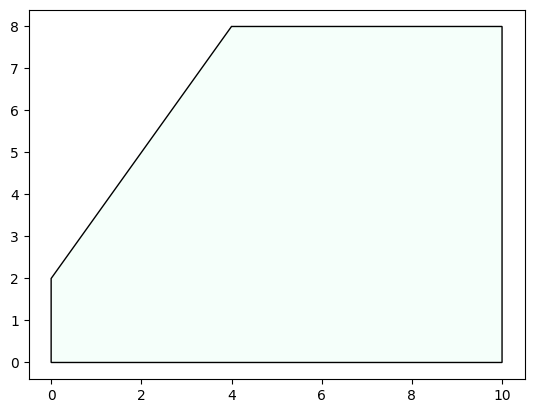

In [3]:
# Collision free set in world frame
S_coll_free_W = Polyhedron.from_vertices(([0, 0], [10, 0], [10, 8], [4, 8], [0, 2]))
print("A:\n", S_coll_free_W.set.A())
print("b:\n", np.round(S_coll_free_W.set.b(), 3))
S_coll_free_W.plot()

The first row of A and b correspond to the horizontal line at $y=0$, and specifies that all points must have $y\geq 0$. The normal of that halfspace is $[0,-1]$. The sloped line has a normal of $[-0.83,0.55]$ and corresponds to the inequality $-0.83x + 0.55y \leq 1.1$. The $b$ in $Ax\leq b$ is also the offset from the origin in the direction of the normal. What we want to do is find out how much to offset each element in $b$ so that if the center of an axis aligned rectangle is within the offset halfspace, no point on the rectangle will protrude from the original halfspace. To do this we can use the formula for projecting one vector onto another vector and project the vector from the center of the rectangle to one of its corners onto the normal of the halfspace and the magnitude of that projection will be the amount we need to offset the halfspace by. https://en.wikipedia.org/wiki/Vector_projection

In [4]:
def scalar_proj_u_onto_v(u, v):
    u = np.array(u)
    v = np.array(v)
    return np.dot(u, v) / np.linalg.norm(v)

One thing we need to be careful about for our use case is the signs of each element of the vectors. We want to choose the half diagonal of the rectangle that is closest in direction to the normal of the halfspace.

In [5]:
def calc_rect_center_offset_from_halfspace(halfspace_normal, rect_lengths):
    """Returns the scalar offset in the normal direction that needs to be subtracted from the current offset such that the rect will not protrude from the original halfspace."""
    halfspace_normal = np.array(halfspace_normal)
    rect_lengths = np.array(rect_lengths)
    assert halfspace_normal.shape[0] == rect_lengths.shape[0]
    u = rect_lengths / 2 * np.sign(halfspace_normal)
    return scalar_proj_u_onto_v(u, halfspace_normal)

For a slightly more complex example to make sure all the signs are right, and the offsets are in the right direction.

Polyhedron is bounded True


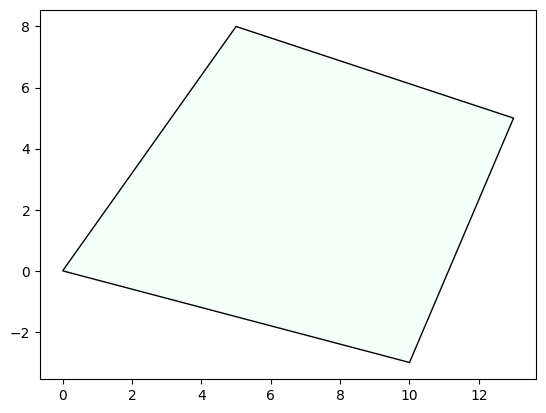

In [6]:
S_coll_free_W = Polyhedron.from_vertices(([0, 0], [10, -3], [13, 5], [5, 8]))
S_coll_free_W.plot()

Polyhedron is bounded True


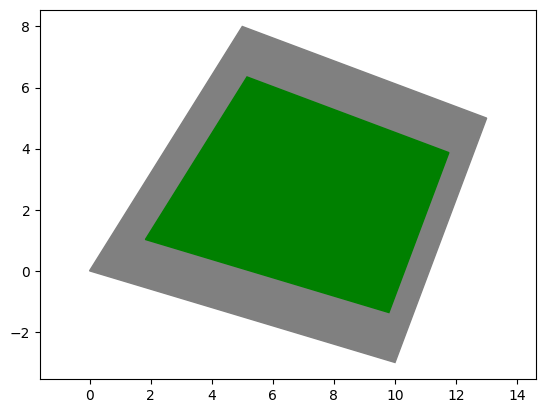

In [7]:
obj_lengths = [0.5, 3]  # width, height
rob_radius = 1


def plot_square(center, radius):
    bottom_left = np.array(center) - radius
    width = 2 * radius
    square = patches.Rectangle(
        bottom_left, width, width, linewidth=1, edgecolor="r", facecolor="none"
    )
    plt.gca().add_patch(square)


def plot_rectangle(center, width, height):
    bottom_left = np.array(center) - np.array([width / 2, height / 2])
    rect = patches.Rectangle(
        bottom_left, width, height, linewidth=1, edgecolor="r", facecolor="none"
    )
    plt.gca().add_patch(rect)
    plt.scatter(center[0], center[1], c="r", s=3)


def plot_circle(center, radius):
    circle = patches.Circle(
        center, radius, linewidth=1, edgecolor="r", facecolor="none"
    )
    plt.gca().add_patch(circle)
    plt.scatter(center[0], center[1], c="r", s=3)


def offset_halfspace_eqns_by_rect(A, b, rect_lengths):
    A = np.array(A)
    b = np.array(b)
    rect_lengths = np.array(rect_lengths)

    assert A.shape[0] == b.shape[0]
    assert A.shape[1] == rect_lengths.shape[0]

    for i in range(A.shape[0]):
        offset = calc_rect_center_offset_from_halfspace(A[i], rect_lengths)
        b[i] -= offset
    return b


def offset_halfspace_eqns_by_sphere(b, radius):
    b = np.array(b)
    b -= radius
    return b


A = S_coll_free_W.set.A()
b = S_coll_free_W.set.b()
b_offset = offset_halfspace_eqns_by_rect(A, b, obj_lengths)
fig = plt.figure()
S_coll_free_W.plot(c="gray")
offset_set = Polyhedron(A, b_offset)
offset_set.plot(c="green")
plt.axis("equal")
plt.show()

And now to double-check that the rectangles centered in the inner polyhedron don't exceed the outer polyhedron, we can use this function that randomly generates samples.

Polyhedron is bounded True


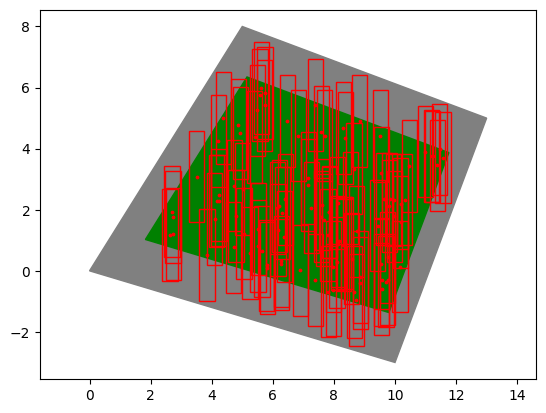

In [8]:
def get_samples_from_set(convex_set, n_samples=1000):
    samples = []
    generator = RandomGenerator(seed=1)
    samples.append(convex_set.set.UniformSample(generator))
    for i in range(n_samples - 1):
        samples.append(
            convex_set.set.UniformSample(generator, previous_sample=samples[-1])
        )
    return samples


offset_set = Polyhedron(A, b_offset)
samples = get_samples_from_set(offset_set, 100)

fig = plt.figure()
S_coll_free_W.plot(c="gray")
offset_set.plot(c="green")
for sample in samples:
    plot_rectangle(sample, *obj_lengths)
plt.axis("equal")
plt.show()

Testing the sphere offset alone

Polyhedron is bounded True


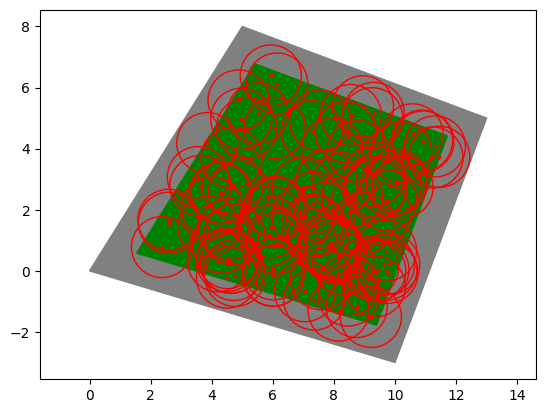

In [9]:
b_sphere_offset = offset_halfspace_eqns_by_sphere(b, rob_radius)
fig = plt.figure()
S_coll_free_W.plot(c="gray")
offset_set = Polyhedron(A, b_sphere_offset)
samples = get_samples_from_set(offset_set, 100)
offset_set.plot(c="green")
for sample in samples:
    plot_circle(sample, rob_radius)
plt.axis("equal")
plt.show()

Now let's check that the polyhedron formed out of all the halfspaces of the offset by rect and offset by sphere inequalities is right

Polyhedron is bounded True


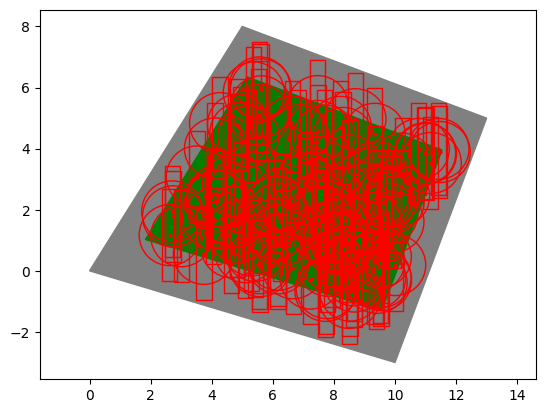

In [10]:
b_rect_offset = offset_halfspace_eqns_by_rect(A, b, obj_lengths)
b_sphere_offset = offset_halfspace_eqns_by_sphere(b, rob_radius)
A_combined = np.vstack((A, A))
b_combined = np.hstack((b_rect_offset, b_sphere_offset))

offset_set = Polyhedron(A_combined, b_combined)
samples = get_samples_from_set(offset_set, 100)

fig = plt.figure()
S_coll_free_W.plot(c="gray")
offset_set.plot(c="green")
for sample in samples:
    plot_rectangle(sample, *obj_lengths)
    plot_circle(sample, rob_radius)
plt.axis("equal")
plt.show()

Now I'm going to try making the set in the higher dimensional configuration space for the robot being to the right of the object and in contact, and every other face not being in contact.

In [11]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(6, "x")
A = S_coll_free_W.set.A()
b = S_coll_free_W.set.b()
rob_b_offset = offset_halfspace_eqns_by_sphere(b, rob_radius)
rob_collision_free_exprs = A @ x[0:2, np.newaxis] - rob_b_offset[:, np.newaxis]

obj_b_offset = offset_halfspace_eqns_by_rect(A, b, obj_lengths)
obj_collision_free_exprs = A @ x[2:4, np.newaxis] - obj_b_offset[:, np.newaxis]

# Enforcing that the relative position of the robot and object
# aligns with the positions of the robot and object in the world frames
p_ObjRob_W = x[0:2] - x[2:4]
p_ObjRob_Obj = x[4:6]
# To get the equality, I need to do both p_ObjRob_W - p_ObjRob_Obj <= 0 and p_ObjRob_Obj - p_ObjRob_W <= 0
rob_obj_W_enforce_equality_exprs = np.hstack(
    (p_ObjRob_W - p_ObjRob_Obj, p_ObjRob_Obj - p_ObjRob_W)
)[:, np.newaxis]

# robot is to the right of the object
# rob_radius + obj_lengths[0]/2 <= p_ObjRob_Obj
rob_obj_relative_exprs = np.array([rob_radius + obj_lengths[0] / 2 - p_ObjRob_Obj[0]])[
    :, np.newaxis
]

combined_exprs = np.vstack(
    (
        rob_collision_free_exprs,
        obj_collision_free_exprs,
        rob_obj_W_enforce_equality_exprs,
        rob_obj_relative_exprs,
    )
)
print(combined_exprs.shape)
print(combined_exprs)

A_higher_dim, b_higher_dim = DecomposeAffineExpressions(combined_exprs, x)
print(A_higher_dim.shape)
print(A_higher_dim)
print(b_higher_dim.shape)
print(b_higher_dim)

(13, 1)
[[<Expression "(0.99999999999997768 - 0.28734788556634538 * x(0) - 0.95782628522115132 * x(1))">]
 [<Expression "(-9.4166621004556443 + 0.93632917756904455 * x(0) - 0.3511234415883917 * x(1))">]
 [<Expression "(0.99999999999997768 - 0.84799830400508802 * x(0) + 0.52999894000318004 * x(1))">]
 [<Expression "(-8.2462506284943373 + 0.3511234415883917 * x(0) + 0.93632917756904455 * x(1))">]
 [<Expression "(1.5085763992232912 - 0.28734788556634538 * x(2) - 0.95782628522115132 * x(3))">]
 [<Expression "(-9.6558946436807958 + 0.93632917756904455 * x(2) - 0.3511234415883917 * x(3))">]
 [<Expression "(1.0069979860060199 - 0.84799830400508802 * x(2) + 0.52999894000318004 * x(3))">]
 [<Expression "(-7.7539760017436725 + 0.3511234415883917 * x(2) + 0.93632917756904455 * x(3))">]
 [<Expression "(x(0) - x(2) - x(4))">]
 [<Expression "(x(1) - x(3) - x(5))">]
 [<Expression "( - x(0) + x(2) + x(4))">]
 [<Expression "( - x(1) + x(3) + x(5))">]
 [<Expression "(1.25 - x(4))">]]
(13, 6)
[[-0.287347

In [12]:
S_higher_dim = Polyhedron(A_higher_dim, -b_higher_dim)

Polyhedron is bounded True


RuntimeError: QH6023 qhull input error: feasible point is not clearly inside halfspace
feasible point: 3.078947368421021 0.1203464403647244 1.82894736842102 1.026315789473672   1.25 -0.9059693491089474 
     halfspace: -0.2873478855663454 -0.9578262852211513      0      0      0      0 
     at offset: 0.9999999999999777  and distance: 9.992007221626409e-16 
The halfspace was at index 0

While executing:  | qhull H
Options selected for Qhull 2020.2.r 2020/08/31:
  run-id 1768728637  Halfspace  _maxoutside  0
